In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path

In [2]:
image_dir = Path('/home/dsw/data/kaggle/mole/')
model_dir = '.'

# Read in the data

In [3]:
images = get_image_files(image_dir, check_ext='jpg', recurse=True)
images[500:505]

[PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0029660.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0031935.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0030940.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0032883.jpg'),
 PosixPath('/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0031979.jpg')]

In [4]:
x = '/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0029660.jpg'

In [5]:
image_rel = ['/'.join(str(x).split('/')[-2:]) for x in images]
image_rel[:5]

['HAM10000_images_part_2/ISIC_0031185.jpg',
 'HAM10000_images_part_2/ISIC_0033579.jpg',
 'HAM10000_images_part_2/ISIC_0034120.jpg',
 'HAM10000_images_part_2/ISIC_0029875.jpg',
 'HAM10000_images_part_2/ISIC_0030941.jpg']

In [6]:
image_key = [x.stem for x in images]
image_dict = dict(zip(image_key,zip(images, image_rel)))
image_df = pd.DataFrame.from_dict(image_dict, orient='index', columns=['f_path', 'dirname'])
image_df.head()

,f_path,dirname
ISIC_0031185,/home/dsw/data/kaggle/mole/HAM10000_images_par...,HAM10000_images_part_2/ISIC_0031185.jpg
ISIC_0033579,/home/dsw/data/kaggle/mole/HAM10000_images_par...,HAM10000_images_part_2/ISIC_0033579.jpg
ISIC_0034120,/home/dsw/data/kaggle/mole/HAM10000_images_par...,HAM10000_images_part_2/ISIC_0034120.jpg
ISIC_0029875,/home/dsw/data/kaggle/mole/HAM10000_images_par...,HAM10000_images_part_2/ISIC_0029875.jpg
ISIC_0030941,/home/dsw/data/kaggle/mole/HAM10000_images_par...,HAM10000_images_part_2/ISIC_0030941.jpg


In [7]:
mole_df = pd.read_csv(image_dir/'HAM10000_metadata.csv')
mole_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
model_df = pd.merge(mole_df, image_df, left_on='image_id', right_index=True, sort=False, validate='1:1')

In [9]:
pd.options.display.max_colwidth = 100
model_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,f_path,dirname
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0027419.jpg,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0025030.jpg,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0026769.jpg,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/dsw/data/kaggle/mole/HAM10000_images_part_1/ISIC_0025661.jpg,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/dsw/data/kaggle/mole/HAM10000_images_part_2/ISIC_0031633.jpg,HAM10000_images_part_2/ISIC_0031633.jpg


In [10]:
bs = 128
transforms = get_transforms()

In [11]:
data = ImageDataBunch.from_df(path=image_dir, df=model_df, seed=9878, fn_col='dirname', label_col='dx')

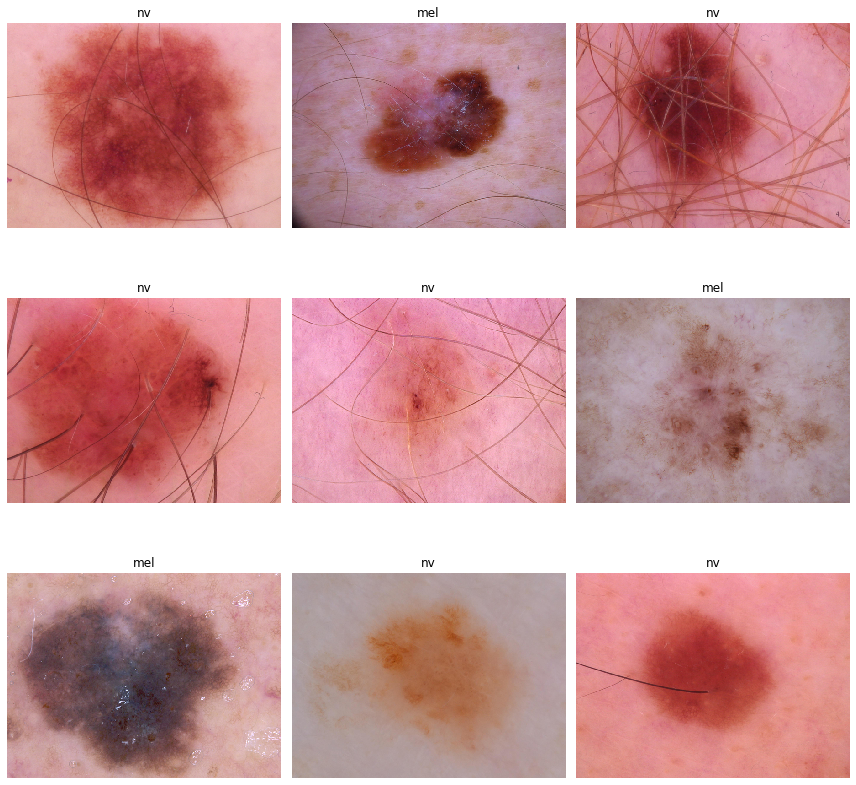

In [12]:
data.show_batch(rows=3)

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], 7, 8012, 2003)

In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate, model_dir=model_dir)
learn.model = torch.nn.DataParallel(learn.model)

# 29	0.005424	0.552628	0.099351	02:46

In [17]:
learn = cnn_learner(data, models.vgg19_bn, metrics=error_rate, model_dir=model_dir)
learn.model = torch.nn.DataParallel(learn.model)

In [14]:
dir(models)

['BasicBlock',
 'Darknet',
 'DynamicUnet',
 'ResLayer',
 'ResNet',
 'SqueezeNet',
 'UnetBlock',
 'WideResNet',
 'XResNet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'darknet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet1_0',
 'squeezenet1_1',
 'unet',
 'vgg16_bn',
 'vgg19_bn',
 'wrn',
 'wrn_22',
 'xception',
 'xresnet',
 'xresnet101',
 'xresnet152',
 'xresnet18',
 'xresnet34',
 'xresnet50']

In [19]:
learn = cnn_learner(data, models.densenet201, metrics=error_rate, model_dir=model_dir)
learn.model = torch.nn.DataParallel(learn.model)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/dsw/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 41.3MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


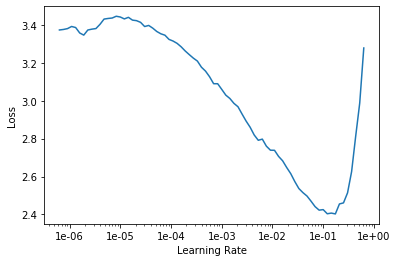

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 0.01

In [22]:
learn.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.444601,0.781231,0.220669,02:36
1,0.837619,0.616275,0.195207,02:26
2,0.594070,0.607738,0.199201,02:26
3,0.511480,0.519615,0.176236,02:25
4,0.468337,0.587959,0.168747,02:23
5,0.404711,0.496024,0.158762,02:23
6,0.301845,0.627728,0.152771,02:24
7,0.277838,0.533006,0.163255,02:23
8,0.218263,0.513342,0.130804,02:24
9,0.158327,0.799281,0.151772,02:23


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, slice(1e-6, 1e-7))